# 5. Application de classification sur le MNIST dataset

Dans ce notebook, deux réseaux de neurones convolutifs probabilistes sont construits pour classer le dataset MNIST ainsi qu'un dataset MNIST corrompu. Le premier modèle probabiliste servira à capturer l'incertitude résiduelle, et le deuxième permettra d'estimer l'incertitude épistémique.

## Importation des librairies

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
tfd = tfp.distributions
tfpl = tfp.layers
import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Importation des données

Commençons par importer nos deux datasets: le MNIST original, et un MNIST corrompu avec des taches, disponibles dans les [TensorFlow datasets](https://www.tensorflow.org/datasets/catalog/mnist_corrupted).

In [3]:
def load_data(name):
    ds, info = tfds.load(name, split=["train", "test"], batch_size=-1, as_supervised=True, with_info=True)
    X_train, y_train = tfds.as_numpy(ds[0])
    X_test, y_test = tfds.as_numpy(ds[1])
    X_train = 1 - X_train/255.
    X_test = 1 - X_test/255.
    y_train_oh = tf.keras.utils.to_categorical(y_train)
    y_test_oh = tf.keras.utils.to_categorical(y_test)
    return (X_train, y_train, y_train_oh), (X_test, y_test, y_test_oh)

In [4]:
def inspect_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, ..., 0], cmap="gray")
        ax[i].axis("off")
    plt.show()

**MNIST original**

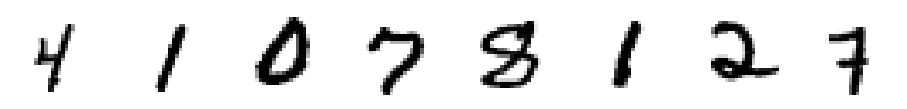

In [5]:
(X_train, y_train, y_train_oh), (X_test, y_test, y_test_oh) = load_data("MNIST_corrupted")
inspect_images(data=X_train, num_images=8)

**MNIST corrompu**

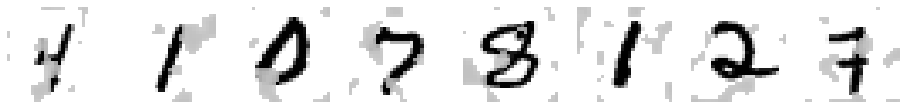

In [6]:
(X_c_train, y_c_train, y_c_train_oh), (X_c_test, y_c_test, y_c_test_oh) = load_data("MNIST_corrupted/spatter")
inspect_images(data=X_c_train, num_images=8)

## Modèle CNN déterministe

Commençons avec un CNN standard déterministe comme modèle de base de classification. Le réseau se compose d'une seule couche convolutive suivie d'une de Pooling, et d'une couche de sortie avec dix neurones, correspondant aux catégories des images de 0 à 9.

In [7]:
def get_deterministic_model(input_shape, loss, optimizer, metrics):
    model = Sequential([
        Conv2D(input_shape=input_shape, filters=8, kernel_size=(5, 5), activation='relu', padding='valid'),
        MaxPooling2D(pool_size=(6, 6)),
        Flatten(),
        Dense(units=10, activation='softmax')
    ])
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [8]:
tf.random.set_seed(0)
deterministic_model = get_deterministic_model(
    input_shape=(28, 28, 1), 
    loss=SparseCategoricalCrossentropy(), 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

In [9]:
deterministic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


In [10]:
deterministic_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.9824 - accuracy: 0.7234
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1600 - accuracy: 0.9533
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1262 - accuracy: 0.9626
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1047 - accuracy: 0.9675
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0966 - accuracy: 0.9703


In [11]:
print(
    'Accuracy on MNIST test set:',
    f'{deterministic_model.evaluate(X_test, y_test, verbose=False)[1]:.3f}'
)
print(
    'Accuracy on corrupted MNIST test set:',
    f'{deterministic_model.evaluate(X_c_test, y_c_test, verbose=False)[1]:.3f}'
)

Accuracy on MNIST test set: 0.973
Accuracy on corrupted MNIST test set: 0.946


Les performances du réseau déterministe sont légèrement inférieures sur le MNIST corrompu car le réseau est entraîné sur le MNIST original et n'a pas vu le bruit ajouté dans le MNIST corrompu.

## Modèle CNN probabiliste

Transformons maintenant le réseau en réseau probabiliste en donnant en sortie une *distribution* au lieu de valeurs discrètes. Ce modèle nous permettra de capturer l'incertitude résiduelle dans le label des images. Deux modifications sont nécessaires:
- ajout d'une couche probabiliste en sortie du modèle, ici une couche `OneHotCategorical`. Elle peut être vue comme une distribution de Bernoulli multi-dimensionnelle.
- entraînement du modèle par la log-vraisemblance négative.

### Définition du modèle probabiliste

In [12]:
def negative_log_likelihood(y_true, y_pred):
    """Negative log likelihood."""
    return -y_pred.log_prob(y_true)

In [13]:
def get_probabilistic_model(input_shape, loss, optimizer, metrics):
    model = Sequential([
        Conv2D(input_shape=input_shape, filters=8, kernel_size=(5, 5), activation='relu', padding='valid'),
        MaxPooling2D(pool_size=(6, 6)),
        Flatten(),
        Dense(units=tfpl.OneHotCategorical.params_size(10)),
        tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
    ])
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


In [14]:
tf.random.set_seed(0)
probabilistic_model = get_probabilistic_model(
    input_shape=(28, 28, 1), 
    loss=negative_log_likelihood, 
    optimizer=RMSprop(), 
    metrics=['accuracy']
)

In [15]:
probabilistic_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
one_hot_categorical (OneHotC multiple                  0         
Total params: 1,498
Trainable params: 1,498
Non-trainable params: 0
_________________________________________________________________


### Entraînement du modèle

In [16]:
probabilistic_model.fit(X_train, y_train_oh, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9824 - accuracy: 0.7236
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1599 - accuracy: 0.9531
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1260 - accuracy: 0.9624
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1046 - accuracy: 0.9678
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0966 - accuracy: 0.9703


In [17]:
print(
    'Accuracy on MNIST test set:',
    f'{probabilistic_model.evaluate(X_test, y_test_oh, verbose=False)[1]:.3f}'
)
print(
    'Accuracy on corrupted MNIST test set:',
    f'{probabilistic_model.evaluate(X_c_test, y_c_test_oh, verbose=False)[1]:.3f}'
)

Accuracy on MNIST test set: 0.973
Accuracy on corrupted MNIST test set: 0.946


Nous obtenons les mêmes performances sur les deux datasets qu'avec le modèle déterministe. En effet, les architectures des deux modèles sont équivalentes, la seule différence est que le modèle probabiliste retourne une distribution. 

### Analyse des prédictions

#### Fonctions

In [20]:
def analyse_and_plot_model_predictions(data, true_labels, model, image_num, run_ensemble=False, ensemble_size=100):
    """
    Make plots of the probabilities that the model estimates for a given image
    """
    if run_ensemble == False:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i, :] = model(image[np.newaxis, :]).mean().numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    
    fig, (ax1, ax2) = plt.subplots(
        nrows=1, ncols=2, figsize=(10, 2), gridspec_kw={'width_ratios': [2, 4]}
    )
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))
    
    if run_ensemble:
        pct_low = np.array([np.percentile(predicted_probabilities[:, i], 16) for i in range(10)])
        pct_up = np.array([np.percentile(predicted_probabilities[:, i], 84) for i in range(10)]) 
    else:
        pct_low = model(image[np.newaxis, :]).mean().numpy()[0] - model(image[np.newaxis, :]).stddev().numpy()[0]
        pct_up = model(image[np.newaxis, :]).mean().numpy()[0] + model(image[np.newaxis, :]).stddev().numpy()[0]
    bar = ax2.bar(np.arange(10), pct_up, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_low-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_title('Model estimated probabilities') 
    plt.show()

#### Premier exemple: prédiction quasi-certaine

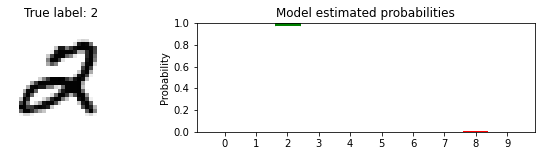

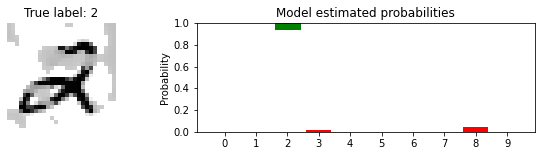

In [25]:
i = 0
analyse_and_plot_model_predictions(X_test, y_test, probabilistic_model, i)
analyse_and_plot_model_predictions(X_c_test, y_c_test, probabilistic_model, i)

#### Deuxième exemple: prédiction plus incertaine

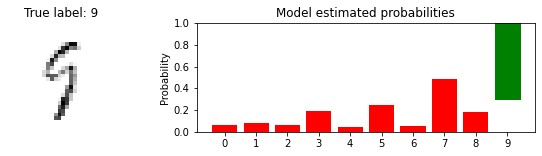

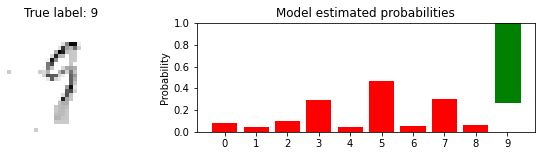

In [26]:
i = 1576
analyse_and_plot_model_predictions(X_test, y_test, probabilistic_model, i)
analyse_and_plot_model_predictions(X_c_test, y_c_test, probabilistic_model, i)

#### Troisième exemple: prédiction complètement incertaine

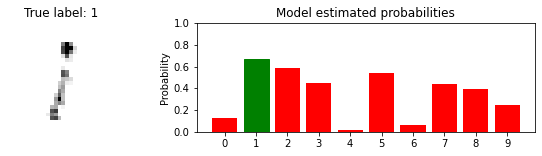

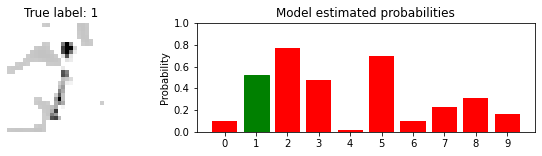

In [27]:
i = 5896
analyse_and_plot_model_predictions(X_test, y_test, probabilistic_model, i)
analyse_and_plot_model_predictions(X_c_test, y_c_test, probabilistic_model, i)

## Modèle CNN bayésien

Notre modèle probabiliste précédent considérait unique l'incertitude aléatoire ou résiduelle. Créons maintenant un CNN bayésien qui inclut des distributions sur les poids du réseau. Pour ce faire, nous allons:
- transformer la couche `Conv2D` en couche `Convolution2DReparameterization`
- transformer la couche `Dense` en `DenseVariational`
- définir un prior. Nous utilisons ici une distribution de type "Spike and Slab" qui est une somme de deux distributions normales, la première ayant un écart-type égal à 1, la deuxième ayant un écart type de 10. Nous obtenons ainsi une distribution plus "large" qu'une distribution normale classique et nous permet d'explorer un domaine plus grand de poids.
- définir un posterior variationnel. Nous considérons ici une distribution normale indépédente.

### Prior

In [29]:
def spike_and_slab(event_shape, dtype):
    "Define the spike and slab distribution."
    distribution = tfd.Mixture(
        cat=tfd.Categorical(probs=[0.5, 0.5]),
        components=[
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=1.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1),
            tfd.Independent(tfd.Normal(
                loc=tf.zeros(event_shape, dtype=dtype), 
                scale=10.0*tf.ones(event_shape, dtype=dtype)),
                            reinterpreted_batch_ndims=1)],
    name='spike_and_slab')
    return distribution

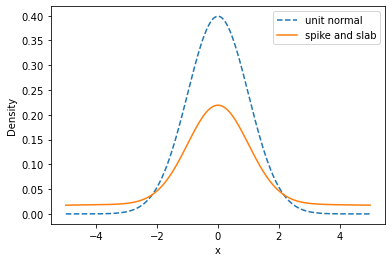

In [30]:
# Plot the spike and slab distribution pdf
x_plot = np.linspace(-5, 5, 1000)[:, np.newaxis]
plt.plot(x_plot, tfd.Normal(loc=0, scale=1).prob(x_plot).numpy(), label='unit normal', linestyle='--')
plt.plot(x_plot, spike_and_slab(1, dtype=tf.float32).prob(x_plot).numpy(), label='spike and slab')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

In [31]:
def prior(kernel_size, bias_size, dtype=None):
    """
    Prior returning a "Spike and Slab distribution".
    """
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t: spike_and_slab(n, dtype)
        )
    ])
    return prior_model

### Posterior

In [32]:
def posterior(kernel_size, bias_size, dtype=None):
    """
    Posterior returning an Independent Normal distribution.
    """
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
        tfpl.IndependentNormal(n)
    ])

### Création du BNN bayésien

In [33]:
# Create the layers
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]
convolutional_reparameterization_layer = tfpl.Convolution2DReparameterization(
    input_shape=(28, 28, 1), 
    filters=8, 
    kernel_size=(5, 5), 
    activation='relu',
    padding='valid', 
    kernel_prior_fn=tfpl.default_multivariate_normal_fn,
    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    kernel_divergence_fn=divergence_fn,
    bias_prior_fn=tfpl.default_multivariate_normal_fn,
    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    bias_divergence_fn=divergence_fn
)
dense_variational_layer = tfpl.DenseVariational(
    units=tfpl.OneHotCategorical.params_size(10),
    make_prior_fn=prior,
    make_posterior_fn=posterior,
    kl_weight=1/X_train.shape[0]
)

In [34]:
bayesian_model = Sequential([
    convolutional_reparameterization_layer,
    MaxPooling2D(pool_size=(6, 6)),
    Flatten(),
    dense_variational_layer,
    tfpl.OneHotCategorical(10, convert_to_tensor_fn=tfd.Distribution.mode)
])
bayesian_model.compile(
    loss=negative_log_likelihood,
    optimizer=RMSprop(),
    metrics=['accuracy'],
    experimental_run_tf_function=False
)

In [35]:
bayesian_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization (C (None, 24, 24, 8)         416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_variational (DenseVari (None, 10)                2580      
_________________________________________________________________
one_hot_categorical_1 (OneHo multiple                  0         
Total params: 2,996
Trainable params: 2,996
Non-trainable params: 0
_________________________________________________________________


### Entraînement du modèle

In [36]:
bayesian_model.fit(x=X_train, y=y_train_oh, epochs=10, verbose=True)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 2.4484 - accuracy: 0.1790
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.8404 - accuracy: 0.7306
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4236 - accuracy: 0.8717
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3016 - accuracy: 0.9151
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2452 - accuracy: 0.9321
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2142 - accuracy: 0.9399
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1931 - accuracy: 0.9487
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1803 - accuracy: 0.9536
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1768 - accuracy: 0.9549
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.164

In [37]:
# Evaluate the model
print('Accuracy on MNIST test set: ',
      f'{bayesian_model.evaluate(X_test, y_test_oh, verbose=False)[1]:.3f}'
)
print('Accuracy on corrupted MNIST test set: ',
      f'{bayesian_model.evaluate(X_c_test, y_c_test_oh, verbose=False)[1]:.3f}'
)

Accuracy on MNIST test set:  0.963
Accuracy on corrupted MNIST test set:  0.926


### Analyse des prédictions

#### Premier exemple: prédiction quasi-certaine

MNIST predicted by Bayesian Model


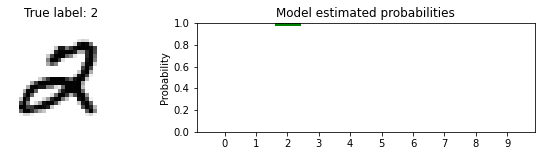

Corrupted MNIST predicted by Bayesian Model


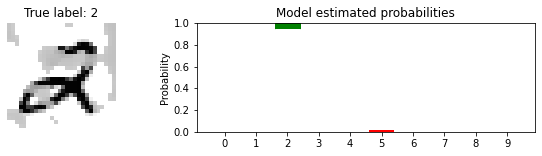

In [41]:
i = 0
print("MNIST predicted by Bayesian Model")
analyse_and_plot_model_predictions(X_test, y_test, bayesian_model, i, run_ensemble=True)
print("Corrupted MNIST predicted by Bayesian Model")
analyse_and_plot_model_predictions(X_c_test, y_c_test, bayesian_model, i, run_ensemble=True)

#### Deuxième exemple: prédiction plus incertaine

MNIST predicted by Bayesian Model


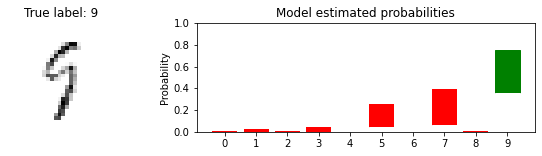

Corrupted MNIST predicted by Bayesian Model


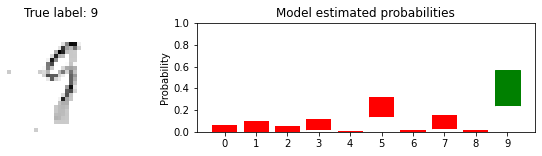

In [39]:
i = 1576
print("MNIST predicted by Bayesian Model")
analyse_and_plot_model_predictions(X_test, y_test, bayesian_model, i, run_ensemble=True)
print("Corrupted MNIST predicted by Bayesian Model")
analyse_and_plot_model_predictions(X_c_test, y_c_test, bayesian_model, i, run_ensemble=True)

#### Troisième exemple: prédiction complètement incertaine

MNIST predicted by Bayesian Model


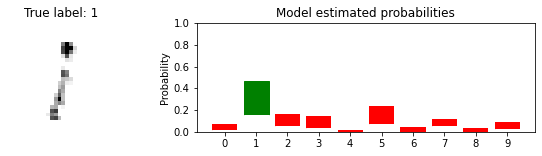

Corrupted MNIST predicted by Bayesian Model


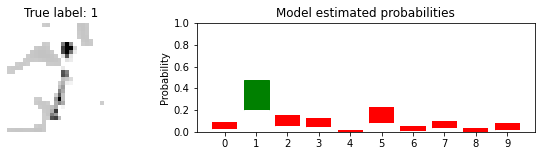

In [40]:
i = 5896
print("MNIST predicted by Bayesian Model")
analyse_and_plot_model_predictions(X_test, y_test, bayesian_model, i, run_ensemble=True)
print("Corrupted MNIST predicted by Bayesian Model")
analyse_and_plot_model_predictions(X_c_test, y_c_test, bayesian_model, i, run_ensemble=True)

## Quantification des incertitudes avec l'entropie

Nous pouvons également analyser l'incertitude du modèle sur l'ensemble du jeu de test, plutôt que sur des valeurs individuelles. Une façon de le faire est de calculer l'[entropie](https://en.wikipedia.org/wiki/Entropy_%28information_theory%29) de la distribution. L'entropie est l'information attendue (ou, de manière informelle, la "surprise" attendue) d'une variable aléatoire, et constitue une mesure de l'incertitude de la variable aléatoire. L'entropie des probabilités estimées pour l'échantillon $i$ est définie comme suit

$$
H_i = -\sum_{j=1}^{10} p_{ij} \text{log}_{2}(p_{ij})
$$

où $p_{ij}$ est la probabilité que le modèle attribue à l'échantillon $i$ correspondant au label $j$. Comme ci-dessus, l'entropie est mesurée en _bits_. Si l'on utilise le logarithme naturel à la place, l'entropie est mesurée en _nats_.

Le point clé est que plus la valeur est élevée, plus le modèle est incertain. Regardons la distribution de l'entropie des prédictions du modèle sur les jeux de test MNIST et MNIST corrompu. Les graphiques seront divisés entre les prédictions correctes et incorrectes du modèle.

### Fonctions

In [25]:
# Functions to plot the distribution of the information entropy across samples,
# split into whether the model prediction is correct or incorrect
def get_correct_indices(model, x, labels):
    y_model = model(x)
    correct = np.argmax(y_model.mean(), axis=1) == np.squeeze(labels)
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices


def plot_entropy_distribution(model, x, labels):
    probs = model(x).mean().numpy()
    entropy = -np.sum(probs * np.log2(probs), axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = entropy[get_correct_indices(model, x, labels)[i]]
        mean_entropy = np.mean(entropy_category)
        num_samples = entropy_category.shape[0]
        title = category + 'ly labelled ({:.1f}% of total)'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f} bits'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy (bits)')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
    plt.show()

### Modèle probabiliste

MNIST test set:


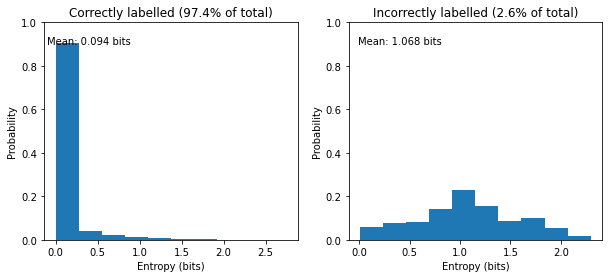

In [26]:
# Entropy plots for the MNIST dataset
print('MNIST test set:')
plot_entropy_distribution(probabilistic_model, X_test, y_test)

Corrupted MNIST test set:


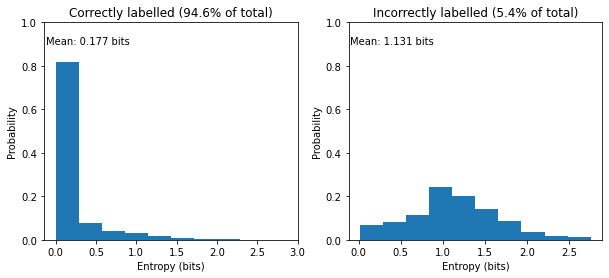

In [27]:
# Entropy plots for the MNIST-C dataset

print('Corrupted MNIST test set:')
plot_entropy_distribution(probabilistic_model, X_c_test, y_c_test)

### Modèle bayésien

MNIST test set:


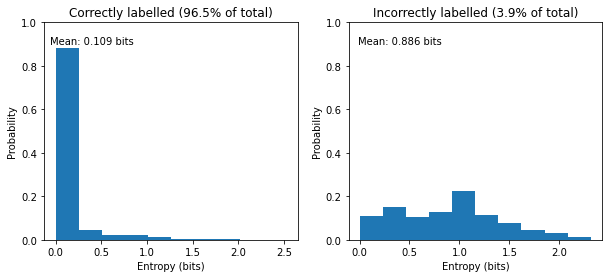

In [97]:
print('MNIST test set:')
plot_entropy_distribution(bayesian_model, X_test, y_test)

Corrupted MNIST test set:


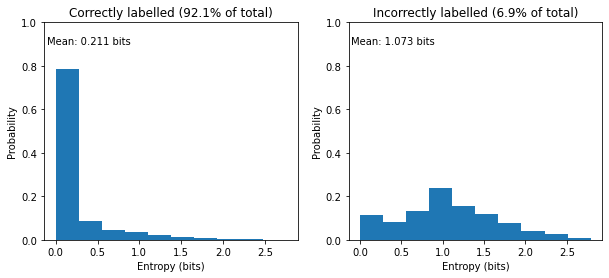

In [98]:
print('Corrupted MNIST test set:')
plot_entropy_distribution(bayesian_model, X_c_test, y_c_test)

Deux conclusions principales ressortent sur l'analyse de l'entropie:
- Le modèle est plus incertain sur les prédictions erronées : cela signifie qu'il "sait" quand la prédiction peut être fausse.
- Le modèle est plus incertain pour le test MNIST corrompu que pour la version non corrompue. En outre, ce phénomène est plus prononcé pour les prédictions correctes que pour celles qu'il étiquette de manière incorrecte.

De cette façon, le modèle semble "savoir" quand il est incertain. C'est une excellente propriété pour un modèle d'apprentissage automatique, et c'est l'un des avantages de la modélisation probabiliste.